### Imports

In [6]:
import numpy as np
import pandas as pd
import tensorflow as tf
import sklearn as skl
import matplotlib.pyplot as plt
import seaborn as sb
from pathlib import Path
import glob
import os

### To do:
1. Clean data file to check for bad recordings. (abs(value) > 313)
2. Keep the recording number so that it is correctly mapped to the video output
3. 

# Merge Original Data file into 1 CSV file

In [18]:
csv_files = glob.glob("cam_output/*/Data.csv")
all_dfs = []
for file_path in csv_files:
    source_folder = os.path.basename(os.path.dirname(file_path))
    df = pd.read_csv(file_path, header=0)
    df["source_folder"] = source_folder
    all_dfs.append(df)
    
merged_df = pd.concat(all_dfs, ignore_index=True)
merged_df.to_csv("merged_sensor_data.csv", index=False)

# Clean Merged Data file

In [21]:
import pandas as pd
from pathlib import Path

def clean_csv(file_path):
    df = pd.read_csv(file_path) # Read data into csv file
    
    cols_to_check = ['ax', 'ay', 'az', 'gx', 'gy', 'gz'] # Columns to check by label
    
# Step 1: Find bad recordings per source_folder
    invalid_recordings = (
        df.groupby(['source_folder', 'recording'])[cols_to_check]
        .apply(lambda g: (g.abs() >= 313).any().any())
    )

    # Get the (source_folder, recording) tuples to drop
    recordings_to_drop = invalid_recordings[invalid_recordings].index.tolist()

    # Step 2: Drop invalid recordings
    df_clean = df.copy()
    for source, rec in recordings_to_drop:
        df_clean = df_clean[~((df_clean['source_folder'] == source) & (df_clean['recording'] == rec))]

    # Re-label recordings within each source_folder
    df_clean = df_clean.copy()

    # for folder in df_clean['source_folder'].unique():
    #     mask = df_clean['source_folder'] == folder
    #     # unique_recordings = df_clean.loc[mask, 'recording'].unique()
    #     # new_labels = {old: new for new, old in enumerate(sorted(unique_recordings), start=1)}
    #     # df_clean.loc[mask, 'recording'] = df_clean.loc[mask, 'recording'].map(new_labels)


    # Step 4: Save cleaned file
    original_path = Path(file_path)
    new_file_path = original_path.with_name(original_path.stem + '_cleaned.csv')
    df_clean.to_csv(new_file_path, index=False)
    print(f"✅ Cleaned CSV saved to: {new_file_path}")

# Example usage:
clean_csv('merged_sensor_data.csv')

✅ Cleaned CSV saved to: merged_sensor_data_cleaned.csv


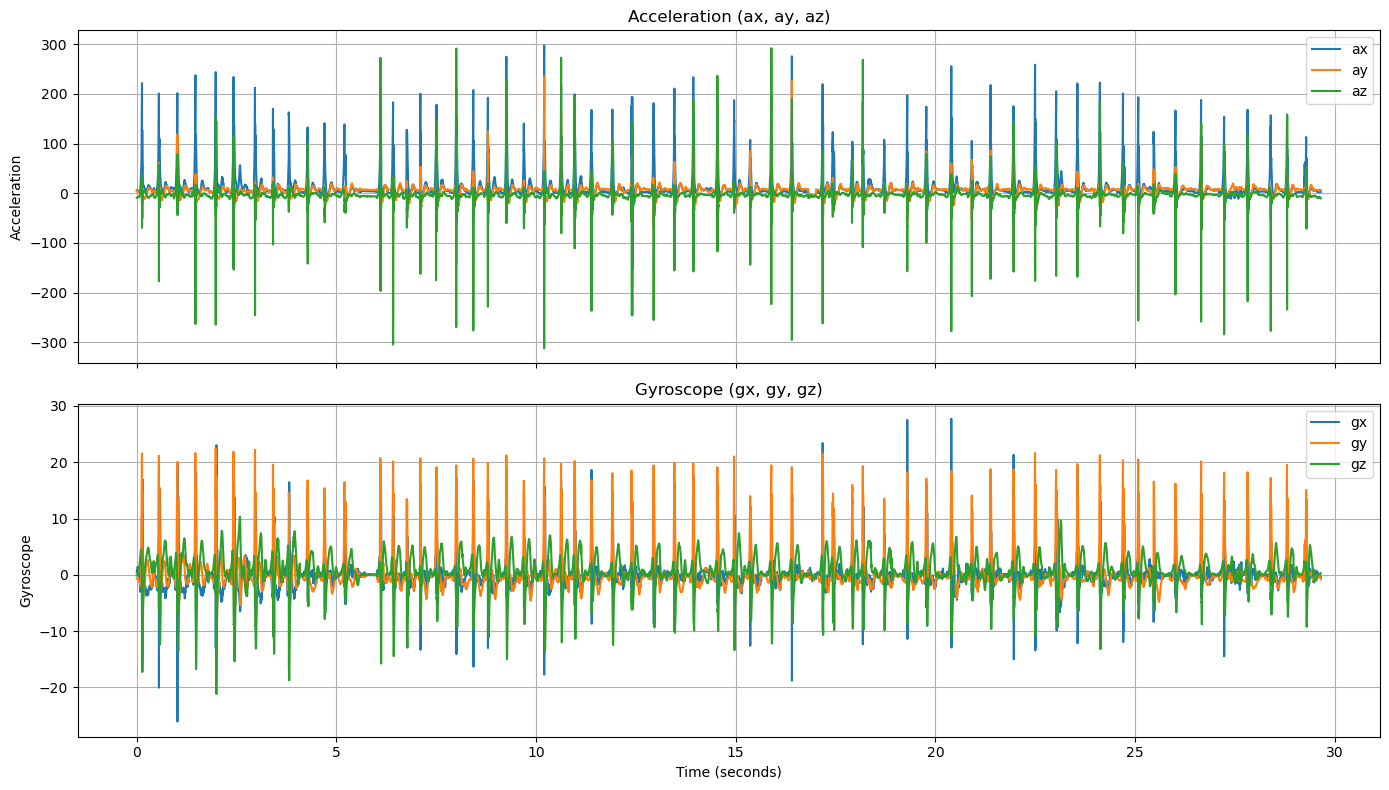

In [22]:
import pandas as pd
import matplotlib.pyplot as plt

# Load cleaned data
df = pd.read_csv('merged_sensor_data_cleaned.csv')

# Convert index to time in seconds
time_sec = df.index / 1000  # 1000 samples = 1 second

# Columns for acceleration and gyroscope
accel_cols = ['ax', 'ay', 'az']
gyro_cols = ['gx', 'gy', 'gz']

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# Plot acceleration data
for col in accel_cols:
    ax1.plot(time_sec, df[col], label=col)
ax1.set_ylabel('Acceleration')
ax1.set_title('Acceleration (ax, ay, az)')
ax1.legend()
ax1.grid(True)

# Plot gyroscope data
for col in gyro_cols:
    ax2.plot(time_sec, df[col], label=col)
ax2.set_ylabel('Gyroscope')
ax2.set_xlabel('Time (seconds)')
ax2.set_title('Gyroscope (gx, gy, gz)')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

